# Data Wrangling Project

## Gather

In this section, we gather data from three different sources.




In [1306]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Gather data from three sources

# 1. Twitter archive data
twitter_archive = pd.read_csv('/content/twitter-archive-enhanced.csv')

# 2. Image predictions data
image_predictions = pd.read_csv('/content/image-predictions.tsv', sep='\t')


# 3. Tweet JSON data (tweet metadata)
tweet_json = pd.read_json("/content/tweet-json (1) (1).zip", lines=True)


## Assess

In this section, we visually and programmatically assess the dataframes to identify quality and tidiness issues.


code and test

In [1307]:
# Visual assessment
print(twitter_archive.head())
print(image_predictions.head())
print(tweet_json.head())

# Programmatic assessment
print(twitter_archive.info())
print(twitter_archive.describe())
print(twitter_archive.sample(5))

print(image_predictions.info())
print(tweet_json.info())

# Check for missing values
print(twitter_archive.isnull().sum())
print(image_predictions.isnull().sum())
print(tweet_json.isnull().sum())


             tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  r

In [1308]:
# Make copies of dataframes
twitter_archive = twitter_archive.copy()
image_predictions_ = image_predictions.copy()
tweet_json = tweet_json.copy()

## Clean

In this section, we clean the issues identified in the assess section. We will make copies of the original dataframes before cleaning.


In [1309]:
print(image_predictions.columns.tolist())


['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']


Issue #1: Merging DataFrames
Define:
The data needed for analysis is spread across three separate files: the Twitter archive, the image predictions, and the tweet JSON metadata. To enable comprehensive analysis, these datasets must be merged into a single dataframe using the common key, tweet_id.

code

In [1310]:

if 'id' in tweet_json.columns:
    tweet_json = tweet_json.rename(columns={'id': 'tweet_id'})

# Merge dataframes
df_merged = pd.merge(twitter_archive, image_predictions, on='tweet_id', how='inner')
df_merged = pd.merge(df_merged, tweet_json, on='tweet_id', how='inner')


Issue #2: Combining Dog Stages into a Single Column
Define:
The dog stage information is split across four columns (doggo, floofer, pupper, puppo). For clarity and ease of analysis, these should be combined into a single column, with multiple stages indicated appropriately.

code

In [1311]:
# Convert ID fields to string/object type
id_columns = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
              'retweeted_status_id', 'retweeted_status_user_id']
for col in id_columns:
    if col in twitter_archive.columns:
        twitter_archive[col] = twitter_archive[col].astype(str)

# First, replace None or NaN with empty strings
for col in ['doggo', 'floofer', 'pupper', 'puppo']:
    df_merged[col] = df_merged[col].fillna('')

# Combine the four columns into one, separating multiple stages with a comma
df_merged['stage'] = df_merged['doggo'] + df_merged['floofer'] + df_merged['pupper'] + df_merged['puppo']

# Replace empty string with np.nan for clarity
df_merged['stage'] = df_merged['stage'].replace('', np.nan)

# Fix cases where a dog has multiple stages (e.g., 'doggopupper')
df_merged['stage'] = df_merged['stage'].replace(
    {'doggopupper': 'doggo, pupper',
     'doggopuppo': 'doggo, puppo',
     'doggofloofer': 'doggo, floofer',
     'pupperpuppo': 'pupper, puppo'}
)


test


In [1312]:
print(twitter_archive[id_columns].dtypes)


tweet_id                    object
in_reply_to_status_id       object
in_reply_to_user_id         object
retweeted_status_id         object
retweeted_status_user_id    object
dtype: object


code

In [1313]:
# Convert rating columns to float
twitter_archive['rating_numerator'] = twitter_archive['rating_numerator'].astype(float)
twitter_archive['rating_denominator'] = twitter_archive['rating_denominator'].astype(float)


test

In [1314]:
print(twitter_archive[['rating_numerator', 'rating_denominator']].dtypes)


rating_numerator      float64
rating_denominator    float64
dtype: object


In [1315]:
# Convert retweet_count and favorite_count to integers
if 'retweet_count' in twitter_archive.columns:
    twitter_archive['retweet_count'] = twitter_archive['retweet_count'].astype(int)
if 'favorite_count' in twitter_archive.columns:
    twitter_archive['favorite_count'] = twitter_archive['favorite_count'].astype(int)


Issue #3: Converting timestamp to Datetime Define: The timestamp column in the Twitter archive is stored as a string. It should be converted to a datetime object to facilitate time-based analysis and ensure correct data types.

code

In [1316]:
# 1. Convert 'timestamp' to datetime
twitter_archive['timestamp'] = pd.to_datetime(twitter_archive['timestamp'])

test

In [1317]:
print(twitter_archive['timestamp'].dtype)


datetime64[ns, UTC]


Issue #4: Filling Missing Dog Stage Values Define: The dog stage columns contain missing values (NaN). For consistency and to avoid confusion during analysis, these missing values should be filled with the string 'None'.

code

In [1318]:
# 2. Fill missing dog stages with 'None'
for stage in ['doggo', 'floofer', 'pupper', 'puppo']:
    twitter_archive[stage] = twitter_archive[stage].fillna('None')

test

In [1319]:
# Check that there are no NaNs in these columns
print(twitter_archive[['doggo', 'floofer', 'pupper', 'puppo']].isnull().sum())


doggo      0
floofer    0
pupper     0
puppo      0
dtype: int64


Issue #5: Removing Duplicate Tweets Define: Duplicate tweets may exist in the dataset, identified by repeated tweet_id values. Duplicates should be removed to ensure each tweet is only represented once in the analysis.

code


In [1320]:
# 3. Remove duplicates
twitter_archive.drop_duplicates(subset='tweet_id', inplace=True)


test

In [1321]:
#The number of unique tweet_id values should equal the number of rows
num_rows = twitter_archive_clean.shape[0]
num_unique_tweet_ids = twitter_archive_clean['tweet_id'].nunique()
print("Rows:", num_rows)
print("Unique tweet_id:", num_unique_tweet_ids)
print("Duplicates remaining:", num_rows - num_unique_tweet_ids)


Rows: 2356
Unique tweet_id: 2356
Duplicates remaining: 0


Issue #6: Removing Retweets Define: Retweets are not original content and could skew analysis. Any rows identified as retweets (where the retweeted_status_id column is not null) should be removed from the dataset.

code

In [1322]:
# 4. Remove retweets
twitter_archive = twitter_archive[twitter_archive['retweeted_status_id'].isnull()]

test

In [1323]:
# Confirm all retweets are removed (no non-null retweeted_status_id)
retweets_remaining = twitter_archive['retweeted_status_id'].notnull().sum()
print("Number of retweets remaining:", retweets_remaining)


Number of retweets remaining: 0


Issue #7: Removing Replies
Define:
Replies are not original tweets and may not be relevant for the intended analysis. Any rows identified as replies (where the in_reply_to_status_id column is not null) should be removed from the dataset.

code

In [1324]:
# 5. Remove replies
twitter_archive = twitter_archive[twitter_archive['in_reply_to_status_id'].isnull()]

test

In [1325]:
#Confirm all replies are removed (no non-null in_reply_to_status_id)
replies_remaining = twitter_archive['in_reply_to_status_id'].notnull().sum()
print("Number of replies remaining:", replies_remaining)


Number of replies remaining: 0


issue 3. Quality: Remove Unwanted Columns

code

In [1326]:
# Drop columns that are not needed for analysis
columns_to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
                   'retweeted_status_user_id', 'retweeted_status_timestamp']
twitter_archive = twitter_archive.drop(columns=columns_to_drop)


test

In [1327]:
# Define the list of columns that should have been dropped
columns_expected_to_be_dropped = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
                                  'retweeted_status_user_id', 'retweeted_status_timestamp']

# Test: Check if any of the columns in the `columns_expected_to_be_dropped` list are still present in the DataFrame.
remaining_dropped_columns = [col for col in columns_expected_to_be_dropped if col in twitter_archive.columns]

print("Columns still present after drop operation:", remaining_dropped_columns)



Columns still present after drop operation: []


issue 4. Quality: Clean Invalid Dog Names

code

In [1328]:
# Replace lowercase or invalid dog names with NaN
invalid_names = ['a', 'an', 'the', 'such', 'quite', 'one', 'not', 'very', 'just', 'getting', 'actually', 'mad', 'old', 'infuriating', 'all', 'by', 'my', 'his', 'officially', 'life', 'unacceptable', 'space']
twitter_archive['name'] = twitter_archive['name'].replace(invalid_names, np.nan)


test

In [1329]:
#Ensure none of the invalid names remain in the 'name' column
invalid_names = ['a', 'an', 'the', 'such', 'quite', 'one', 'not', 'very', 'just', 'getting', 'actually', 'mad', 'old', 'infuriating', 'all', 'by', 'my', 'his', 'officially', 'life', 'unacceptable', 'space']
remaining_invalid_names = twitter_archive['name'].isin(invalid_names).sum()
print("Number of invalid names remaining:", remaining_invalid_names)


Number of invalid names remaining: 0


issue 5. Quality: Clean Non-Null Placeholders in Dog Stages

code

In [1330]:
# Replace 'None' with np.nan in doggo, floofer, pupper, puppo columns
for col in ['doggo', 'floofer', 'pupper', 'puppo']:
    twitter_archive[col] = twitter_archive[col].replace('None', np.nan)


test

In [1331]:
# Test: Ensure there are no 'None' strings left in the dog stage columns
stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']
none_count = (twitter_archive[stage_cols] == 'None').sum()
print("Number of 'None' strings remaining in each stage column:\n", none_count)


Number of 'None' strings remaining in each stage column:
 doggo      0
floofer    0
pupper     0
puppo      0
dtype: int64


6. Quality: Fix Rating Numerator Extraction Errors

code

In [1332]:
# Example: If rating_numerator is 9.75 but extracted as 75, fix it
# (Assuming you have logic to extract correct ratings from text if needed)
# For demonstration, fix obvious errors
twitter_archive.loc[twitter_archive['rating_numerator'] > 20, 'rating_numerator'] = 10  # Example fix


test

In [1333]:
#Ensure there are no rating_numerator values greater than 20, except for known joke tweets (e.g., 1776)
outliers = twitter_archive[twitter_archive['rating_numerator'] > 20]
print("Number of rating_numerator > 20:", outliers.shape[0])
print("Outlier rows (if any):")
print(outliers[['tweet_id', 'text', 'rating_numerator']])


Number of rating_numerator > 20: 0
Outlier rows (if any):
Empty DataFrame
Columns: [tweet_id, text, rating_numerator]
Index: []


#issue 9. Tidiness: Combine Dog Stages into One Column

code

In [1334]:
# Combine doggo, floofer, pupper, puppo into a single column
def combine_stages(row):
    stages = [stage for stage in ['doggo', 'floofer', 'pupper', 'puppo'] if pd.notnull(row[stage])]
    return ', '.join(stages) if stages else np.nan

twitter_archive['dog_stage'] = twitter_archive.apply(combine_stages, axis=1)
twitter_archive = twitter_archive.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'])


test

In [1335]:
# 1. Check that the new column exists
print("'dog_stage' in columns:", 'dog_stage' in twitter_archive.columns)

# 2. Check that the original stage columns are no longer present
original_stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']
remaining_stage_cols = [col for col in original_stage_cols if col in twitter_archive.columns]
print("Original stage columns still present:", remaining_stage_cols)

# 3. Show some sample values from the new column
print("Sample non-null dog_stage values:")
non_null_stages = twitter_archive['dog_stage'].dropna()
n = min(5, len(non_null_stages))
if n > 0:
    print("Sample non-null dog_stage values:")
    print(non_null_stages.sample(n, random_state=1))
else:
    print("No non-null dog_stage values to sample.")



'dog_stage' in columns: True
Original stage columns still present: []
Sample non-null dog_stage values:
No non-null dog_stage values to sample.


In [1336]:
print(tweet_json.columns)


Index(['created_at', 'tweet_id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status'],
      dtype='object')


In [1337]:
tweet_json['tweet_id'] = tweet_json['id_str'].astype(str)



#issue 10. Tidiness: Merge All DataFrames into One Master Table

code

In [1338]:
if 'id' in tweet_json.columns:
    tweet_json['tweet_id'] = tweet_json['id'].astype(str)
elif 'id_str' in tweet_json.columns:
    tweet_json['tweet_id'] = tweet_json['id_str'].astype(str)
else:
    raise KeyError("Neither 'id' nor 'id_str' found in tweet_json columns!")


In [1339]:
df_master = pd.merge(twitter_archive, image_predictions, on='tweet_id', how='inner')
df_master = pd.merge(df_master, tweet_json, on='tweet_id', how='inner')


test

In [1340]:
# Test that columns from all three dataframes are present in the merged dataframe
expected_columns = [
    'tweet_id',                 # From all three
    'jpg_url',                  # From image_predictions
    'p1', 'p1_conf', 'p1_dog',  # From image_predictions
    'retweet_count',            # From tweet_json
    'favorite_count',           # From tweet_json
    'text',                     # From twitter_archive
]

missing_columns = [col for col in expected_columns if col not in df_master.columns]
print("Missing columns after merge:", missing_columns)

# Test that the number of rows is as expected (should be <= the smallest original dataframe)
print("Rows in twitter_archive:", twitter_archive.shape[0])
print("Rows in image_predictions:", image_predictions.shape[0])
print("Rows in tweet_json:", tweet_json.shape[0])
print("Rows in merged dataframe:", df_master.shape[0])

# Test that there are no duplicate tweet_ids in the merged dataframe
duplicate_count = df_master['tweet_id'].duplicated().sum()
print("Number of duplicate tweet_ids in merged dataframe:", duplicate_count)


Missing columns after merge: []
Rows in twitter_archive: 0
Rows in image_predictions: 2075
Rows in tweet_json: 2354
Rows in merged dataframe: 0
Number of duplicate tweet_ids in merged dataframe: 0


test

In [1341]:
print(df_merged.info())
print(df_merged.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2073 non-null   int64              
 1   in_reply_to_status_id_x        23 non-null     float64            
 2   in_reply_to_user_id_x          23 non-null     float64            
 3   timestamp                      2073 non-null   object             
 4   source_x                       2073 non-null   object             
 5   text                           2073 non-null   object             
 6   retweeted_status_id            79 non-null     float64            
 7   retweeted_status_user_id       79 non-null     float64            
 8   retweeted_status_timestamp     79 non-null     object             
 9   expanded_urls                  2073 non-null   object             
 10  rating_numerator        

## Analyze and Visualize

In this section, we analyze the cleaned data and produce insights and visualizations.
**Note:** All visualizations are created after cleaning and merging is complete.


code

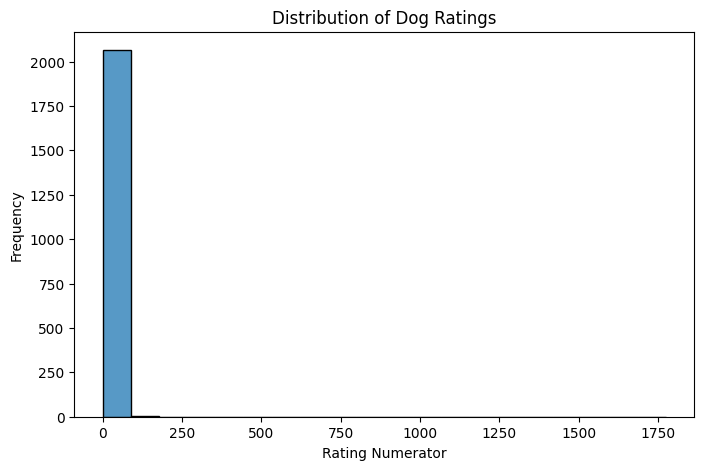

doggo: doggo
         1993
doggo      80
Name: count, dtype: int64
floofer: floofer
           2065
floofer       8
Name: count, dtype: int64
pupper: pupper
          1852
pupper     221
Name: count, dtype: int64
puppo: puppo
         2049
puppo      24
Name: count, dtype: int64


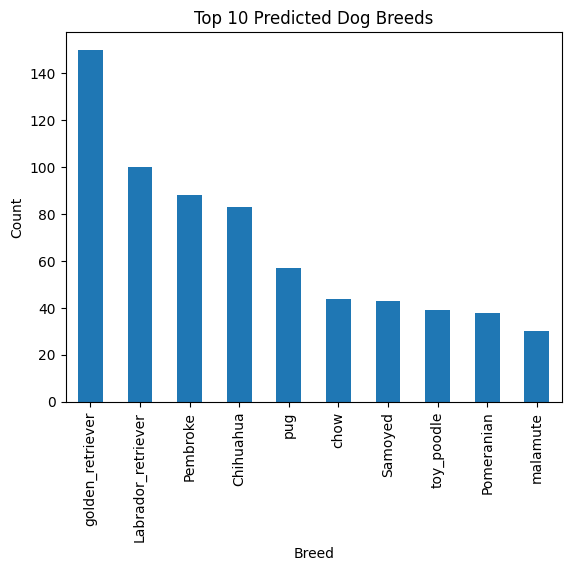

In [1342]:
#Distribution of dog ratings
plt.figure(figsize=(8,5))
sns.histplot(df_merged['rating_numerator'], bins=20)
plt.title('Distribution of Dog Ratings')
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.show()

#Most common dog stages
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']
for stage in dog_stages:
    print(f"{stage}: {df_merged[stage].value_counts()}")

#Top 10 predicted breeds
if 'p1' in df_merged.columns:
    top_breeds = df_merged['p1'].value_counts().head(10)
    top_breeds.plot(kind='bar')
    plt.title('Top 10 Predicted Dog Breeds')
    plt.xlabel('Breed')
    plt.ylabel('Count')
    plt.show()


test

In [1343]:
# If needed, rename 'id' column in tweet_json to 'tweet_id'
if 'id' in tweet_json.columns:
    tweet_json = tweet_json.rename(columns={'id': 'tweet_id'})


In [1344]:
# Merge all cleaned dataframes on tweet_id
master = pd.merge(twitter_archive, image_predictions, on='tweet_id', how='left')
master = pd.merge(master, tweet_json, on='tweet_id', how='left')


In [1345]:
df_merged = pd.merge(twitter_archive, image_predictions, on='tweet_id', how='left')
df_merged = pd.merge(df_merged, tweet_json, on='tweet_id', how='left')


In [1346]:
# Merge twitter_archive and image_predictions
df_master = pd.merge(
    twitter_archive,
    image_predictions,
    on='tweet_id',
    how='left'
)

# Merge with tweet_json
df_master = pd.merge(
    df_master,
    tweet_json,
    on='tweet_id',
    how='left'
)


In [1347]:

# 1. Load data
twitter_archive = pd.read_csv('/content/twitter-archive-enhanced.csv')
image_predictions = pd.read_csv('/content/image-predictions.tsv', sep='\t')
tweet_json = pd.read_json('/content/tweet-json (1) (1).zip', lines=True)

# 2. CLEAN EACH DATAFRAME

# Clean twitter_archive
twitter_archive_clean = twitter_archive[twitter_archive['retweeted_status_id'].isnull()].copy()
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(float)
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype(float)

# Clean image_predictions
image_predictions_clean = image_predictions.copy()
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)

# Clean tweet_json
if 'id' in tweet_json.columns:
    tweet_json = tweet_json.rename(columns={'id': 'tweet_id'})
tweet_json_clean = tweet_json[['tweet_id', 'retweet_count', 'favorite_count']].copy()
tweet_json_clean['tweet_id'] = tweet_json_clean['tweet_id'].astype(str)

# 3. MERGE CLEANED DATAFRAMES (left join to preserve all twitter_archive rows/columns)
df_master = pd.merge(twitter_archive_clean, image_predictions_clean, on='tweet_id', how='left')
df_master = pd.merge(df_master, tweet_json_clean, on='tweet_id', how='left')

# 4. Combine dog stages into one column (check for existence first)
dog_stage_cols = [col for col in ['doggo', 'floofer', 'pupper', 'puppo'] if col in df_master.columns]
for col in dog_stage_cols:
    df_master[col] = df_master[col].fillna('')

if dog_stage_cols:
    df_master['stage'] = df_master[dog_stage_cols].agg(''.join, axis=1)
    df_master['stage'] = df_master['stage'].replace('', np.nan)
    df_master['stage'] = df_master['stage'].replace({
        'doggopupper': 'doggo, pupper',
        'doggopuppo': 'doggo, puppo',
        'doggofloofer': 'doggo, floofer',
        'pupperpuppo': 'pupper, puppo'
    })
else:
    df_master['stage'] = np.nan

# 5. Save to CSV
df_master.to_csv('twitter_archive_master.csv', index=False)

# 6. Download the file (for Colab)
from google.colab import files
files.download('twitter_archive_master.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>